# Code to generate figures 3 and 4 of:

> ## A comprehensive LFQ benchmark dataset to validate data analysis pipelines on modern day acquisition strategies in proteomics.
>
>Bart Van Puyvelde 1, Simon Daled 1, Sander Willems 1, Sigrid Verhelst 1, Ralf Gabriels 2,3, Anne Gonzalez de Peredo 4, David Bouyssié 4, Kurt Boonen 5,6, Lee Gethings 7, Chris Hughes 7, Yasset Perez-Riverol 8, Odile Schiltz 4, Lennart Martens 2,3, Dieter Deforce 1, Johannes P.C. Vissers 7, Maarten Dhaenens 1*
>1. ProGenTomics, Laboratory of Pharmaceutical Biotechnology, Ghent University, Ghent, Belgium
>2. VIB-UGent Center for Medical Biotechnology, VIB, 9000 Ghent, Belgium 
>3. Department of Biomolecular Medicine, Ghent University, 9000 Ghent, Belgium
>4. Institut de Pharmacologie et de Biologie Structural (IPBS), Université de Toulouse, CNRS, UPS, Toulouse, France
>5. VITO Health, Mol, Belgium
>6. Centre for Proteomics, University of Antwerpen, Antwerp, Belgium
>7. Waters Corporation, Milford, MA / Waters Corporation, Wilmslow, UK 
>8. European Molecular Biology Laboratory, European Bioinformatics Institute, Wellcome Genome Campus, Hinxton, UK
>
>*Corresponding author: Maarten Dhaenens (maarten.dhaenens@ugent.be)


To run these scripts, first unzip the input data (all `.peprec`, `_correlations.csv`, and `_pred_and_emp.csv` files, and `protein_overview.csv`) in the same directory as this notebook.

In [1]:
import re
import os
from itertools import combinations, combinations_with_replacement, product
from glob import glob

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

In [3]:
corr_files = [
    ("LFQ_timsTOF_HCD_correlations.csv", "timsTOF Pro", "HCD"),
    ("LFQ_timsTOF_TTOF5600_correlations.csv", "timsTOF Pro", "TTOF5600"),
    ("LFQ_SynaptG2Si_HCD_correlations.csv", "SynaptG2si", "HCD"),
    ("LFQ_SynaptG2Si_TTOF5600_correlations.csv", "SynaptG2si", "TTOF5600"),
    ("LFQ_SynaptXS_HCD_correlations.csv", "SynaptXS", "HCD"),
    ("LFQ_SynaptXS_TTOF5600_correlations.csv", "SynaptXS", "TTOF5600"),
    ("LFQ_5600_HCD_correlations.csv", "TripleTOF 5600", "HCD"),
    ("LFQ_5600_TTOF5600_correlations.csv", "TripleTOF 5600", "TTOF5600"),
    ("LFQ_6600_HCD_correlations.csv", "TripleTOF 6600", "HCD"),
    ("LFQ_6600_TTOF5600_correlations.csv", "TripleTOF 6600", "TTOF5600"),
    ("LFQ_Orbitrap_HCD_correlations.csv", "Orbitrap", "HCD"),
    ("LFQ_Orbitrap_TTOF5600_correlations.csv", "Orbitrap", "TTOF5600"),
]

### Figure 4: MS²PIP correlations

In [4]:
all_corr = []
for f, i, m in corr_files:
    c = pd.read_csv(f, index_col=0)
    c["Model"] = m
    c["Instrument"] = i
    all_corr.append(c)
all_corr = pd.concat(all_corr)
all_corr = all_corr.rename(columns={"pearsonr": "Pearson correlation"})

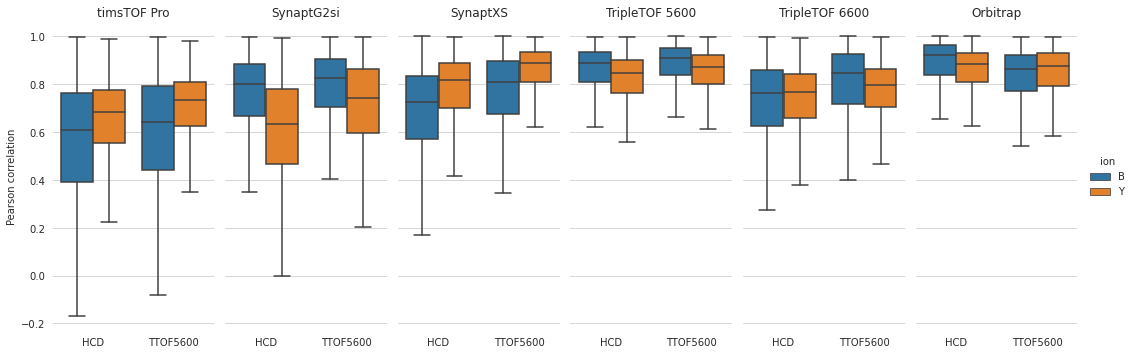

In [5]:
g = sns.catplot(
    data=all_corr, y="Pearson correlation", col="Instrument", x="Model", hue="ion",
    kind="box", orient="v", showfliers=False, aspect=0.5
)

# Remove "instrument=" and "model" labels
for ax, inst in zip(g.axes.flatten(), all_corr["Instrument"].unique()):
    ax.set_title(inst)
    ax.set_xlabel("")

sns.despine(left=True, bottom=True)

plt.savefig("Figure4.svg",bbox_inches="tight", dpi=600, transparent=True) 
plt.show()

### Figure 3C: Correlations between observed spectra

In [6]:
def calc_correlations(df, col1, col2):
    correlations = df.groupby(['peptide_id', 'ion'])[[col1, col2]].corr().iloc[::2][col2]
    correlations.index = correlations.index.droplevel(2)
    correlations = correlations.to_frame().reset_index()
    correlations.rename(columns={col2: 'pearsonr'}, inplace=True)
    return correlations

In [7]:
# Load peprec files
peprec_files = glob("*peprec")
peprec_files_dict = {re.search(r"(.*)_(.*).peprec", pf)[2]: pf for pf in peprec_files}

all_peprec = []
for instrument, peprec_file in peprec_files_dict.items():
    peprec = pd.read_csv(peprec_file, sep=" ")
    peprec["instrument"] = instrument
    all_peprec.append(peprec)
all_peprec = pd.concat(all_peprec)

In [8]:
# Load pred_and_emp files
pae_files = glob("*_pred_and_emp.csv")
pae_files_dict = {re.search(r"LFQ_(.*)_(.*)_pred_and_emp.csv", f)[1]: f for f in pae_files}

all_pae = []
for instrument, pae_file in pae_files_dict.items():
    pae = pd.read_csv(pae_file)
    pae["instrument"] = instrument
    all_pae.append(pae)
all_pae = pd.concat(all_pae)

In [9]:
# Combine pred_and_emp with peprec
all_pae = all_pae.merge(all_peprec.drop("charge", axis=1), on=["spec_id", "instrument"], how="left")

# Check that all spectra in pae have matched with peprec
assert not all_pae["peptide"].isna().any()

# Extract observed intensities per instrument on common peptides
all_pae["peptide_id"] = all_pae.groupby(["peptide", "modifications", "charge"]).ngroup() + 1
all_pae["sequence_id"] = all_pae.groupby(["peptide"]).ngroup() + 1
all_pae["ion_id"] = all_pae.groupby(["peptide_id", "ion", "ionnumber"]).ngroup() + 1
all_emp = all_pae.drop_duplicates(["ion_id", "instrument"]).pivot(index=["sequence_id", "peptide_id", "ion_id"], columns="instrument", values="target")

In [10]:
instruments = all_emp.columns.to_list()

In [11]:
# Get peptide/ion information again
all_emp_info = all_emp.reset_index().merge(all_pae[["charge", "ion", "ionnumber", "ion_id"]], on="ion_id")

In [12]:
# Calculate correlations between all combinations of instruments
all_corr_inst = []
for i1, i2 in combinations(instruments, 2):
    c = calc_correlations(
        all_emp_info[~all_emp_info[[i1, i2]].isna().any(axis=1)],
        i1, 
        i2
    )
    c["instrument 1"] = i1
    c["instrument 2"] = i2
    all_corr_inst.append(c)
all_corr_inst = pd.concat(all_corr_inst)

In [13]:
# Get medians
all_corr_inst_median = (
    all_corr_inst
    .groupby(["instrument 1", "instrument 2"])["pearsonr"].median()
    .reset_index()
    .pivot(columns="instrument 1", index="instrument 2", values="pearsonr")
)

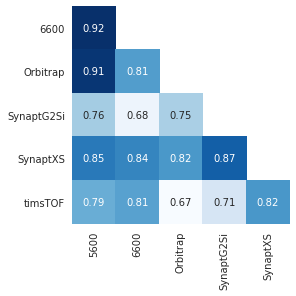

In [14]:
sns.heatmap(all_corr_inst_median,cmap = "Blues",annot=True, fmt=".2f", square=True, cbar=False)
plt.xlabel("")
plt.ylabel("")
plt.savefig("Figure3C.svg",bbox_inches="tight", dpi=600, transparent=True) 
plt.show()

### Overlap in identifications between instruments
#### Figure 3B: In terms of precursors (sequence, modifications, charge)

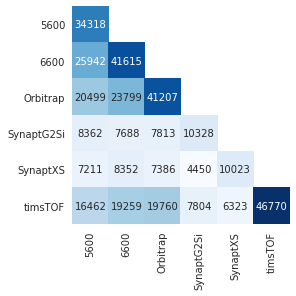

In [15]:
overlap_peptides = []
for i1, i2 in combinations_with_replacement(instruments, 2):
    overlap = all_emp[[i1, i2]].dropna(axis=0).index.get_level_values("sequence_id").unique().shape[0]
    overlap_peptides.append([i1, i2, overlap])

overlap_peptides = pd.DataFrame(overlap_peptides).pivot(columns=0, index=1, values=2)

sns.heatmap(overlap_peptides, cmap = "Blues",annot=True, fmt=".0f", square=True, cbar=False)
plt.xlabel("")
plt.ylabel("")
plt.savefig("Figure3A.svg", bbox_inches="tight", dpi=600, transparent=True)
plt.show()

#### Figure 3A: In terms of proteins

In [16]:
df = pd.read_csv("protein_overview.csv", sep=";")
counts = (~df.isna()).sum().reset_index()
counts.columns = ["Instrument", "Identified proteins"]
counts

Instrument  Identified proteins
0        5600                 4989
1        6600                 5722
2    Orbitrap                 7141
3     timsTOF                 8988
4  SynaptG2Si                 2667
5    SynaptXS                 1903

In [17]:
instruments = list(df.columns)
protein_id_sets = {i: set(df[i].dropna()) for i in df}

overlap_counts = []
for i1, i2 in combinations_with_replacement(sorted(instruments), 2):
    overlap_counts.append((i1, i2, len(protein_id_sets[i1].intersection(protein_id_sets[i2]))))

overlap_counts_df = pd.DataFrame(overlap_counts)

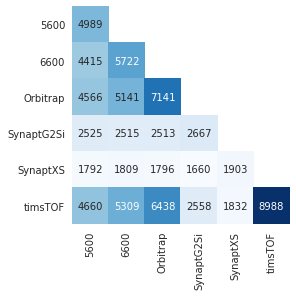

In [18]:
sns.heatmap(
    data=overlap_counts_df.pivot(index=1, columns=0, values=2),
    annot=True, fmt=".0f", square=True, cbar=False, cmap="Blues"
)

plt.xlabel("")
plt.ylabel("")
plt.savefig("Figure3B.svg", transparent=True,bbox_inches="tight",dpi=600)
plt.show()